# Data Pipeline
This notebook creates the dataset from individual process tables. It will use the *_Booking Table_* to reconstruct the recipe of a given design (SAP number) and batch (WA number)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import sys
sys.path.append('../')
from process_pipeline.core.sequencer import Sequencer
from process_pipeline.utils import fix_duplicate_columns, fix_format_columns, nested_dict_from_pandas
from process_pipeline.core.modules import  get_df_lookup

In [2]:
#_______________________________________________________________________________________________________________________________________________
#___OPTIONS_____________________________________________________________________________________________________________________________________
create_lookup = False
run_ist = False
run_process = True
load_file = True

#_______________________________________________________________________________________________________________________________________________
#___CONSTANTS & DEFINITIONS_____________________________________________________________________________________________________________________

format = "%m/%d/%y %I:%M %p"
input_data_path = "../data/input/"
intermediate_data_path = "../data/intermediate/"
output_data_path = "../data/output/"

filename_sel  = intermediate_data_path +"lookup_selected.xlsx"
filename_look = intermediate_data_path +"lookup.xlsx"


## To Delete

In [63]:

#_______________________________________________________________________________________________________________________________________________
#___ACTIVE FUNCTIONS____________________________________________________________________________________________________________________________

# def fix_duplicate_columns(df):
#     """Fixes n-times repeated names from a pandas DataFrame adding a suffix "_n"
    
#     Example: df.columns = Time, Value, Time, Variable, Time
#     ---> new columns = Time_1, Value, Time_2, Variable, Time_3

#     Args:
#         df (pandas DataFrame): DataFrame containing multiple columns with the same name
#     """
#     columns = df.columns
#     seen = np.array([])
#     counter = np.ones(len(columns))
    
#     for i,col in enumerate(columns):
#         if col in seen:
#             counter[i] = counter[i]+1
#         else:
#             seen = np.append(seen,col)
    
#     df_col = pd.DataFrame({"Columns": columns,"Counter": counter})
#     new_cols = np.array([])
    
#     for i in df_col.index:
#         if df_col.at[i,"Counter"] == 1:
#             new_cols = np.append(new_cols,df_col.at[i,"Columns"])
#         else:
#             new_cols = np.append(new_cols,df_col.at[i,"Columns"]+"_"+str(df_col.at[i,"Counter"]))
    
#     df.columns = new_cols
    
# def fix_format_columns(df):
#     """Fix repeated column names of a pandas DataFrame
    
#     Example: df.columns = Time Time, Value Value, First Variable First Variable
#     ---> new columns = Time, Value, First Variable

#     Args:
#         df (pandas DataFrame): DataFrame containing column names formed by repeated identical words
        
#     Returns:
#         pandas DataFrame: DataFrame with fixed columns names
#     """
#     df.columns = ["_".join(df.columns[col].split()[0:int(0.5*len(df.columns[col].split()))]) for col in range(len(df.columns))]
    
#     return df



# def get_df_lookup(dic):
#     """Generates a pandas DataFrame with the columns information of the process in the
#     input dictionary, which can be used as lookup table

#     Args:
#         dic (dictionary): dictionary of the process 

#     Returns:
#         pandas DataFrame: contains information about the process parameters
#     """
    
#     df = dic["df"]
#     machine_label = dic["machine_label"]
#     prefix = dic["prefix"]
    
#     df_pro = pd.DataFrame(df.dtypes,columns=["dtype"])
#     df_pro["variable"] = [prefix +"_"+ str(i) for i in range(len(df_pro))]
    
#     if machine_label is not False:
#         machines = df[machine_label].unique()
#         machines = [x for x in machines if x is not np.nan]
        
#         for machine in machines:
#             df_pro[machine] = np.logical_not(np.array(df[df[machine_label]==machine].isna().mode()).flatten())
    
#     df_pro ["Select"] = False
#     df_pro = df_pro.reset_index()
    
#     for i,par in enumerate(df_pro["index"]):
#         if df[par].dtype.kind in 'biufc':
            
#             df_pro.at[i,"min"] = df[par].min()
#             df_pro.at[i,"max"] = df[par].max()
#             df_pro.at[i,"mean"] = df[par].mean()
#             df_pro.at[i,"std"] = df[par].std()

#     return df_pro

# def createDictFromPandas(df):
#     """Generates a nested dictionary from the pandas DataFrame MultiIndex

#     Args:
#         df (pandas DataFrame): its MultiIndex must be set before with .set_index([Index1, Index2,...])

#     Returns:
#         dict : nested dictionary
#     """
    
#     if (df.index.nlevels==1):
#         return df.index.unique().tolist()
#     dict_f = {}
#     for level in df.index.levels[0]:
#         if (level in df.index):
#             dict_f[level] = createDictFromPandas(df.xs(level))
    
#     return dict_f

def get_data_step_02(WA,step,processes,*args, **kwargs):
    """Looks for the current step within the processes and assembles a 

    Args:
        WA (str): batch number
        step (_type_): _description_
        processes (_type_): _description_

    Raises:
        ValueError: the lookup table doesn't contain any selected parameter

    Returns:
        _type_: _description_
    """
    
    
    for pro in processes:
        
        df_temp = pd.DataFrame()
        missing = None
        
        process_name = pro["process_label"]
        
        if WA in pro["df"][pro["WA_label"]].unique().tolist():
        
            df_cp = pro["df"].set_index(pro["WA_label"]).loc[WA]
            step_list = np.array(df_cp[pro["PaPos_label"]])

            if step in step_list:

                # open the lookup table
                df_lookup = pd.read_excel(filename_sel,sheet_name=pro["process_label"])

                # handle multiple machines on the same dataframe
                if pro["machine_label"] != False:
                    machine = df_cp.iloc[0][pro["machine_label"]]                     # get the right machine from the process df
                    df_lookup = df_lookup[df_lookup[machine]]

                date_label = [i for i in df_lookup["index"] if i in pro["date_label"]]     # get the data_label from the lookup df
                parameters = df_lookup[df_lookup["Select"]]["index"].tolist()              # import only selected parameters ...
                variables = df_lookup[df_lookup["Select"]]["variable"].tolist()

                # check if the parameters have been selected
                if len(parameters) == 0:
                    raise ValueError(f"No selected parameters in the {process_name} lookup table")

                values = df_cp[parameters].apply(np.mean).tolist()
                #time = df_cp[df_cp[date_label].notna()][date_label]
                time = df_cp[date_label]
                
                if len(time) == 1:# pd.Timestamp:
                     time = list(np.array(time))*len(values)
                else:
                     time = list(np.array(time.iloc[0]))*len(values)
                
                # if len(set(map(len,col_list)))==1: 
                #     print("All are the same length") else: print("They are not the same length!")
                    

                # df_temp = pd.DataFrame({"Value"    : values,
                #                         "Time"     : time,
                #                         "Variable" : variables,
                #                         "Process"  : process_name})
                df_temp["Value"] = values
                df_temp["Time"] = time
                df_temp["Variable"] = variables
                df_temp["Process"] = process_name
                
                
                break

                
        else:
            missing = (process_name, WA, step)
    
    return df_temp, missing



#_______________________________________________________________________________________________________________________________________________
#___OUTDATED FUNCTIONS__________________________________________________________________________________________________________________________

# def select_columns(df,col,val):
#     return df.set_index(col).loc[val].reset_index()


# def get_data_step(WA,step,process_dict,max_seq_length,verbose):
    
#     df_process = process_dict["df"][process_dict["df"][process_dict["WA_label"]]==WA]      # select the current WA in the process df
#     process_name = process_dict["process_label"]
    
#     if step in list(df_process[process_dict["PaPos_label"]]):
        
#         if verbose:
#             print(f"WA {WA}, step = {step} found in {process_name}")
        
#         # open the process dataframe and select the step
#         df_process =  df_process[df_process[process_dict["PaPos_label"]]==step]

#         # open the lookup table for the current process
#         df_lookup = pd.read_excel(filename,sheet_name=process_dict["process_label"])        # open the corresponding lookup table

#         # handle multiple machines on the same dataframe
#         if process_dict["machine_label"] != False:
#             machine = df_process.iloc[0][process_dict["machine_label"]]                     # get the right machine from the process df
#             df_lookup = df_lookup[df_lookup[machine]]                                       # select in the lookup df only the machine in use

#         date_label = [i for i in df_lookup["index"] if i in process_dict["date_label"]]     # get the data_label from the lookup df
#         parameters = df_lookup[df_lookup["Select"]]["index"].tolist()                       # import only selected parameters ...
#         variables = df_lookup[df_lookup["Select"]]["variable"].tolist()                     # ... and respective variable names

#         # check if the parameters have been selected
#         if len(parameters) == 0:
#             raise ValueError(f"No selected parameters in the {process_name} lookup table")
        
#         values = df_process[parameters].apply(np.mean).tolist()
#         dates = df_process[date_label].iloc[0].tolist()*len(values)                         # take only the first date
                
#         return [values,variables,dates]
    
#     else:
#         if verbose:
#             print(f"WA {WA}, step = {step} NOT found in {process_name}")

## 1. Import all needed file and store in DataFrames

In [4]:
flag = 0

# Recipe Table
df_rec = fix_format_columns(pd.read_csv(input_data_path+"recipes.csv",sep=";",skiprows=2))

# Booking Table
df_book = fix_format_columns(pd.read_csv(input_data_path+"booking.csv",sep=";"))
df_book["Timestamp"] = pd.to_datetime(df_book["Timestamp"],format = format)

# Process Tables
df_plasma = pd.read_csv(input_data_path + "plasma.csv",sep=";",header=11,low_memory=False)
df_laser = pd.read_csv(input_data_path + "laser.csv",sep=";",header=5,low_memory=False)
df_galva = pd.read_csv(input_data_path + "galvanik.csv",sep=";",header=11,low_memory=False)
df_micro = pd.read_csv(input_data_path + "microetch.csv",sep=";",header=2,low_memory=False)
df_multi = pd.read_csv(input_data_path + "multibond.csv",sep=";",header=2,low_memory=False)

In [5]:
laser_dict = {"df"          : df_laser,
            "process_label" : "Laser",
            "machine_label" : "Machine",
            "WA_label"      : "WA",
            "PaPos_label"   : "PaPosNr",
            "date_label"    : ["TimeStamp","CreateDate 1"],
            "date_format"   : "%m/%d/%y %I:%M %p",
            "prefix"        : "las"}

plasma_dict = {"df"          : df_plasma,
            "process_label" : "Plasma",
            "machine_label" : "Machine",
            "WA_label"      : "WA",
            "PaPos_label"   : "Position",
            "date_label"    : ["Buchungsdatum",],
            "date_format"   : "%m/%d/%y %I:%M %p",
            "prefix"        : "pla"}


galva_dict = {"df"          : df_galva,
            "process_label" : "Galvanic",
            "machine_label" : False,
            "WA_label"      : "WA",
            "PaPos_label"   : "PaPosNr",
            "date_label"    : ["Date/Time Stamp"],
            "date_format"   : "%m/%d/%y %I:%M %p",
            "prefix"        : "gal"}

multi_dict = {"df"          : df_multi,
            "process_label" : "Multibond",
            "machine_label" : False,
            "WA_label"      : "WA",
            "PaPos_label"   : "PaPosNr",
            "date_label"    : ["t_StartDateTime"],
            "date_format"   : "%m/%d/%y %I:%M %p",
            "prefix"        : "mul"}


micro_dict = {"df"          : df_micro,
            "process_label" : "Microetch",
            "machine_label" : False,
            "WA_label"      : "WA",
            "PaPos_label"   : "PaPosNr",
            "date_label"    : ["CreateDate"],
            "date_format"   : "%d.%m.%Y %H:%M:%S",
            "prefix"        : "mic"}

processes_ = [laser_dict,plasma_dict,galva_dict,multi_dict,micro_dict]

In [6]:

class Process():
    def __init__(
        self,
        process_label: str,
        hidden_label : str,
        machine_label: str,
        WA_label: str,
        PaPos_label:str,
        date_label:list,
        date_format : str,
        prefix : str,
        filename:str,
        sep: str,
        header: int
        ):
        self.process_label = process_label
        self.hidden_label = hidden_label
        self.machine_label = machine_label
        self.WA_label = WA_label
        self.PaPos_label = PaPos_label
        self.date_label = date_label
        self.date_format = date_format
        self.prefix = prefix
        self.filename = filename
        self.sep = sep
        self.header = header
        self.flag = 0
        
    def get_df(self,input_data_path):
        self.df = pd.read_csv(input_data_path+self.filename, sep=self.sep,header=self.header,low_memory=False)
        self.flag = 1
        
    def normalize_df(self,filename_sel):
        if self.flag == 0:
            raise ValueError("First call get_df to initialize the daraframe!")
        
        self.df_lookup = pd.read_excel(filename_sel,sheet_name=self.process_label)
        self.parameters = self.df_lookup[self.df_lookup["Select"]]["index"]

        for p in self.parameters:
            self.df[p] = (self.df[p]-self.df[p].min())/(self.df[p].max()-self.df[p].min()+1E-8)
            
    def convert_timestamp(self):
        if self.flag == 0:
            raise ValueError("First call get_df to initialize the daraframe!")
        
        for d in self.date_label:
            self.df[d] = pd.to_datetime(self.df[d],format=self.date_format)


flag = 2
    
        
laser = Process(
    process_label = "Laser",
    hidden_label = "Process_1",
    machine_label = "Machine",
    WA_label = "WA",
    PaPos_label ="PaPosNr",
    date_label = ["TimeStamp","CreateDate 1"],
    date_format ="%m/%d/%y %I:%M %p",
    prefix ="las",
    filename = "laser.csv",
    sep = ";",
    header = 5
)

plasma = Process(
    process_label = "Plasma",
    hidden_label = "Process_2",
    machine_label = "Machine",
    WA_label = "WA",
    PaPos_label ="Position",
    date_label = ["Buchungsdatum",],
    date_format = "%m/%d/%y %I:%M %p",
    prefix ="pla",
    filename = "plasma.csv",
    sep = ";",
    header = 11
)

galvanic = Process(
    process_label = "Galvanic",
    hidden_label = "Process_3",
    machine_label = None,
    WA_label = "WA",
    PaPos_label = "PaPosNr",
    date_label = ["Date/Time Stamp"],
    date_format = "%m/%d/%y %I:%M %p",
    prefix = "gal",
    filename = "laser.csv",
    sep = ";",
    header = 11
)


multibond = Process(
    process_label = "Multibond",
    hidden_label = "Process_4",
    machine_label = None,
    WA_label = "WA",
    PaPos_label ="PaPosNr",
    date_label = ["t_StartDateTime"],
    date_format ="%m/%d/%y %I:%M %p",
    prefix ="mul",
    filename = "multibond.csv",
    sep = ";",
    header = 2
)


microetch = Process(
    process_label = "Microetch",
    hidden_label = "Process_5",
    machine_label = None,
    WA_label = "WA",
    PaPos_label ="PaPosNr",
    date_label = ["CreateDate"],
    date_format = "%d.%m.%Y %H:%M:%S",
    prefix ="mic",
    filename = "microetch.csv",
    sep = ";",
    header = 2
)

processes = [laser, plasma, galvanic, multibond, microetch]

laser.get_df(input_data_path)
laser.normalize_df(filename_sel)

## 2. Create a Lookup table
Insert, in the dictionaries below, the relevant information to import each process table correctly:
- df: the DataFrame object where the measurement file is stored
- process_label" : name of the process
- machine_label" : machine column, set to False if there is only one machine
- WA_label"      : batch column, usually "WA"
- PaPos_label"   : Label for the Process Position
- date_label"    : list of columns that contains dates. Note: select only one column per machine
- date_format"   : date format to convert to timestamp (for example "%m/%d/%y %I:%M %p")
- prefix"        : prefix to give to the 

In [7]:
if create_lookup:
    
    with pd.ExcelWriter(filename_look) as writer:
        
        for process in processes_:
            
            process_name = process["process_label"]
            print(f"Process {process_name}...")
            get_df_lookup(process).to_excel(writer, sheet_name=process["process_label"])
            print("Complete!")


## 3. Select columns (process parameters)  
Open the excel file "Process_Lookup.xlsx" and select the parameters to include in the dataset

## 4. Normalize selected parameters and convert datetime 

In [8]:
#normalize parameters
if flag == 1:
    raise ValueError("First reload the DataFrames!")

for process in processes_:
    process_name = process["process_label"]
    print(f"Normalization for {process_name}...")
    
    df_lookup = pd.read_excel(filename_sel,sheet_name=process["process_label"])
    parameters = df_lookup[df_lookup["Select"]]["index"]
    i = 0
    df_ist = process["df"]
    for p in parameters:
        i +=1
        df_ist[p] = (df_ist[p]-df_ist[p].min())/(df_ist[p].max()-df_ist[p].min()+1E-6)
    print(f"DONE! {i} parameters in total \n")

flag = 1

Normalization for Laser...
DONE! 36 parameters in total 

Normalization for Plasma...
DONE! 58 parameters in total 

Normalization for Galvanic...
DONE! 251 parameters in total 

Normalization for Multibond...
DONE! 109 parameters in total 

Normalization for Microetch...
DONE! 34 parameters in total 



In [9]:
#convert time in Timestamp
if flag == 2:
    raise ValueError("First reload the DataFrames!")

for process in processes_:
    process_name = process["process_label"]
    data_labels = process["date_label"]
    
    print(f"Time conversion for {process_name}...")
    
    for d in data_labels:
        process["df"][d] = pd.to_datetime(process["df"][d],format=process["date_format"])
    
    print(f"DONE!")

flag = 2

Time conversion for Laser...
DONE!
Time conversion for Plasma...
DONE!
Time conversion for Galvanic...
DONE!
Time conversion for Multibond...
DONE!
Time conversion for Microetch...
DONE!


## 5. Read Y file (IST) and assemble X (process chain)

In [10]:
if run_ist:
    %run ../02_IST/IST_Data.ipynb

In [11]:
df_ist = pd.read_csv(intermediate_data_path + "y_ist.csv", sep=",") # read Y (IST) file
#
df_ist = df_ist.iloc[:100000]

# create a nested dictionary from Y (IST) queries
d = nested_dict_from_pandas(df_ist.set_index(["SapNummer","Version","WA","id"]))

In [ ]:
# RUNTIME c.a. 225min (without verbose)
from tqdm import tqdm

verbose = False
verboseprint = print if verbose else lambda *a, **k: None

tot_WA = len(df_ist["WA"].unique())
prog_bar = tqdm(total=tot_WA)

booking_mis = [] # these samples are present in the output but are missing in the booking file
process_mis = [] # these samples are present in the output but are missing in the process(es) file(s)
df_pc = None     # initiate the output process chain DataFrame

if run_process:
    for s in d.keys():
        df_sel = df_book.set_index(["SAP"])
        
        if s in df_sel.index:
        
            for v in d[s].keys():
                df_sel = df_book.set_index(["SAP","SAP_Version"]).loc[int(s)]
                
                if v in df_sel.index:
                
                    for wa in d[s][v].keys():
                        prog_bar.update()
                        
                        df_sel = df_book.set_index(["SAP","SAP_Version","WA"]).loc[int(s)].loc[v]
                        
                        if wa in df_sel.index:
                            df_sel = df_book.set_index(["SAP","SAP_Version","WA"]).loc[int(s)].loc[v].loc[[wa]]
                            
                            verboseprint(f"Current batch: {wa}")
                            df_wa = None
                            
                            # STEP 1 COMPUTE PROCESS CHAIN OF THE GIVEN BATCH
                            #tqdm._instances.clear()
                            step_counter = 0
                            for step in df_sel["PaPosNumber"]:
                                
                                df_temp, mis = get_data_step_02(wa,step,processes_)                           # get data for the current WA, Version and PaPosNumber
                                
                                if mis is not None:
                                    process_mis.append(mis)
                                
                                if df_temp is not None:
                                    df_temp["WA"] = wa                                             # append current design
                                    df_temp["PaPos"] = step                                        # append current step
                                    df_temp["Version"] = v                                         # append current version
                                    df_temp["SAP"] = s                                             # append current design
                                    df_temp["Pos"] = step_counter                                  # append current step counter
                                    
                                    step_counter += 1                                              # increment for next step
    
                                    if df_wa is None:                                              # first loop --> initiate
                                        df_wa = df_temp.copy()
                                        verboseprint("Process Dataframe initialized!")
                                        
                                    else:
                                        df_wa = pd.concat([df_wa,df_temp])                        # from second loop on...append
                                        verboseprint(f"Process Dataframe updated...{wa},{step}")
                                    
                            # STEP 2 DUPLICATE AND APPEND FOR ALL COUPONS IN THE SET
                            if df_wa is not None:
                                id_list = d[s][v][wa]                                              # ID coupons belonging to the same batch/version/design
                                
                                for id in id_list:
                                    df_wa["id"] = id                                               # add ID column with current coupon ID
                                    df_wa["Position"] = [i for i in range(len(df_wa))]
                                    
                                    if df_pc is None:                                              # first loop --> initiate
                                        df_pc = df_wa.copy()
                                        
                                    else:                                                          # from second loop on...append
                                        df_pc = pd.concat([df_pc,df_wa])
                            
                            else:
                                booking_mis.append((s,v,wa))
                        else:
                            booking_mis.append((s,v,wa))
                else:
                    booking_mis.append((s,v,"ALL"))
        else:
            booking_mis.append((s,"ALL","ALL"))
            
    
    # assemble DataFrame of missing data
    df_book_mis = pd.DataFrame(booking_mis, columns=["Design","Version","Batch"])
    df_pro_mis = pd.DataFrame(process_mis, columns=["Process", "Batch", "PaPos"])
    
    # save report of missing data
    df_book_mis.to_csv(intermediate_data_path + "booking_missing.csv", sep=",")
    df_pro_mis.to_csv(intermediate_data_path + "process_missing.csv", sep=",")
    df_pc.to_csv(intermediate_data_path + "x_prochain.csv", sep=",")
    

## 5. Y trimming and align

In [ ]:
if load_file:
    df_pc = pd.read_csv(intermediate_data_path + "x_prochain.csv", sep=",")
    df_book_mis = pd.read_csv(intermediate_data_path + "booking_missing.csv", sep=",")
    df_pro_mis = pd.read_csv(intermediate_data_path + "process_missing.csv", sep=",")
    
else: 
    try: 
        df_pc.head()
    except:
        print("DataFrames not found, opening files from previous sessions...")
        df_pc = pd.read_csv(intermediate_data_path + "x_prochain.csv", sep=",")
        df_book_mis = pd.read_csv(intermediate_data_path + "booking_missing.csv", sep=",")
        df_pro_mis = pd.read_csv(intermediate_data_path + "process_missing.csv", sep=",")

In [ ]:
#check size
len_Y = len(df_ist["id"].unique()) 
len_X = len(df_pc["id"].unique())

print(f"Input vector X {len_X} elements")
print(f"Input vector Y {len_Y} elements")

Input vector X 4968 elements
Input vector Y 5152 elements


In [ ]:
# SIZE CHECK #SLOOOW

# seen missing id during the assembly of the dataset
if run_process:
    seen_missing_id = []
    for i in df_book_mis.index:
        
        sap = df_book_mis.at[i,"Design"]
        ver = df_book_mis.at[i,"Version"]
        wa = df_book_mis.at[i,"Batch"]
    
        if ver == "ALL":
            mis = df_ist.set_index(["SapNummer"]).loc[sap]["id"].unique().tolist()
                
        elif wa == "ALL":
            mis = df_ist.set_index(["SapNummer","Version"]).loc[sap].loc[ver]["id"].unique().tolist()
            
        elif ver != "ALL" and wa != "ALL":
            mis = df_ist.set_index(["SapNummer","Version","WA"]).loc[sap].loc[ver].loc[wa]["id"].unique().tolist()
            
        seen_missing_id.extend(mis)
    
    
    # actual missing id
    actual_missing_id=  []
    for i in df_ist["id"].unique():
        if i not in df_pc["id"].tolist():
            actual_missing_id.append(i)
            
            
    # ID not seen from the method
    unseen_id = []
    for i in actual_missing_id:
        if i not in seen_missing_id:
            unseen_id.append(i)
    
    if len(unseen_id) == 0:
        print("Successful: all missing data are intercepted! You can proceed trimming Y")
        print(f"Elements in X {len_X} + {len(seen_missing_id)} missing = {len_X+len(seen_missing_id)} = {len_Y} elements in Y")
        pass_flag = True
        
    else:
        print("Problem: The method did not intercept all missing data...")
        print(f"The following {unseen_id} are missing")
        pass_flag = False

In [ ]:
# TRIM Y & SAVE

if run_process:

    if pass_flag:
        df_ist_tr = df_ist[np.logical_not([df_ist["id"].iloc[i] in seen_missing_id for i in df_ist.index])]
        df_ist_tr = df_ist_tr.sort_values("id")

        alignment_bool = df_ist_tr["id"].all() == df_pc["id"].all()
        df_ist_tr.to_csv(intermediate_data_path + "y_trimmed.csv", sep=",")
        new_Y_length = len(df_ist_tr["id"].unique())
        print(f"New Y size {new_Y_length} = {len_X} X size")

    else:
        raise TabError("The result of the previous cell was negative, fix it before proceeding!")
    
else:
    df_ist_tr = pd.read_csv(intermediate_data_path + "y_trimmed.csv", sep=",")

## 6. Statistical Report

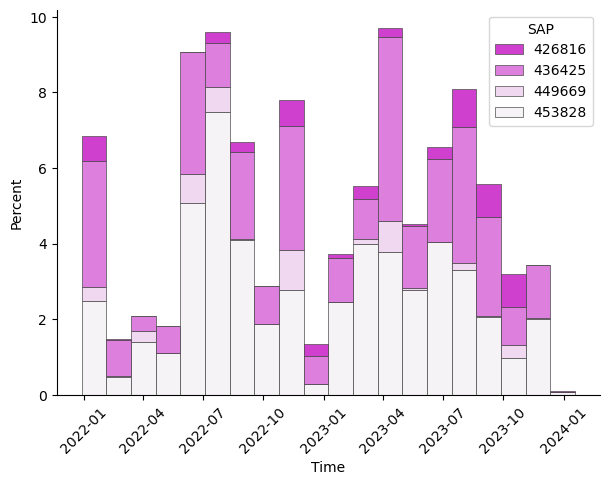

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))

sns.despine(f)

df_plot = df_pc.copy()
df_plot["Time"] = pd.to_datetime(df_plot["Time"]).round("30D")
df_plot = df_plot.sort_values("Time")

sns.histplot(data=df_plot, x="Time", hue="SAP", multiple="stack",
             palette="light:m_r",edgecolor=".3",linewidth=.5,bins=20,stat="percent", ax = ax)

plt.xticks(rotation=45)
plt.show()

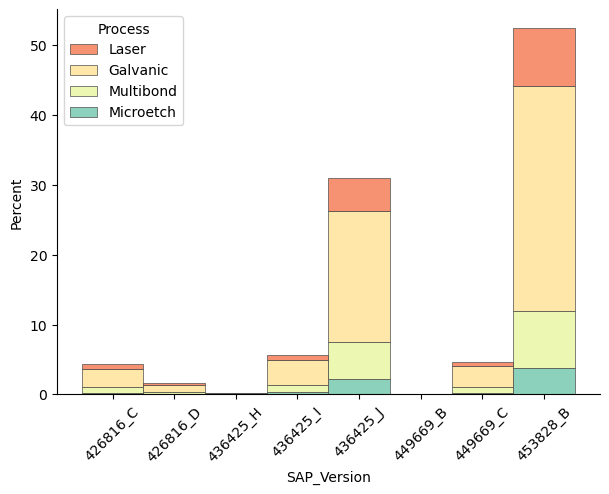

In [ ]:
designs = list(d.keys())

df_plot = df_pc.copy()
df_plot["SAP"] = df_plot["SAP"].apply(lambda x: str(x))
df_plot["SAP_Version"] = df_plot["SAP"]+"_"+df_plot["Version"]

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

    
sns.histplot(data = df_plot ,x="SAP_Version", hue="Process", hue_order=["Laser","Galvanic","Multibond","Microetch"],
                 multiple="stack",
                 palette="Spectral",edgecolor=".3",linewidth=.5,
                 stat="percent")

plt.xticks(rotation=45)
plt.show()
del df_plot

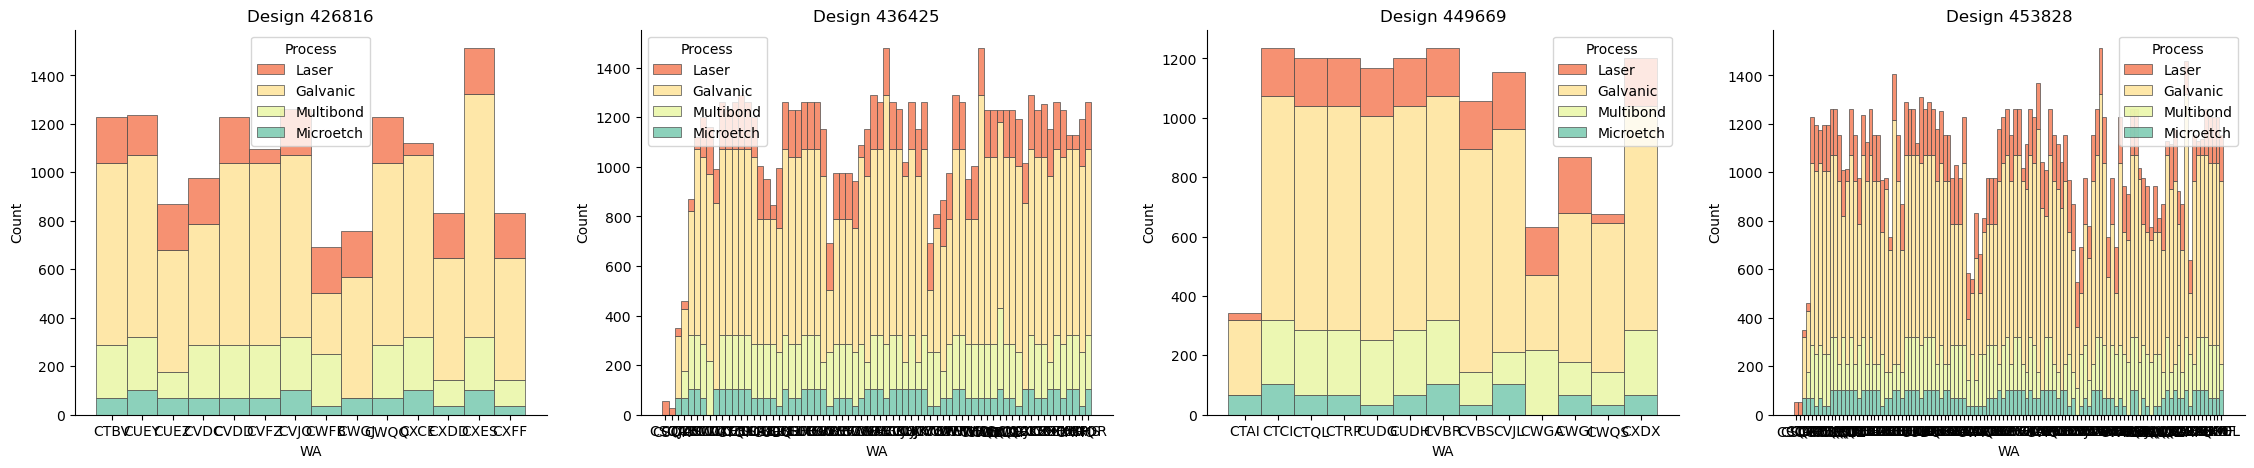

In [ ]:
designs = list(d.keys())

f, ax = plt.subplots(1,len(designs),figsize=(7*len(designs), 5))
sns.despine(f)

for i, sap in enumerate(designs):
    
    df_plot = df_pc.set_index("SAP").loc[sap].drop_duplicates(subset = ["WA","Position"])
    
    sns.histplot(data = df_plot ,x="WA", hue="Process", hue_order=["Laser","Galvanic","Multibond","Microetch"],
                 multiple="stack",palette="Spectral",edgecolor=".3",linewidth=.5,ax=ax[i])
    ax[i].set_title(f"Design {sap}")

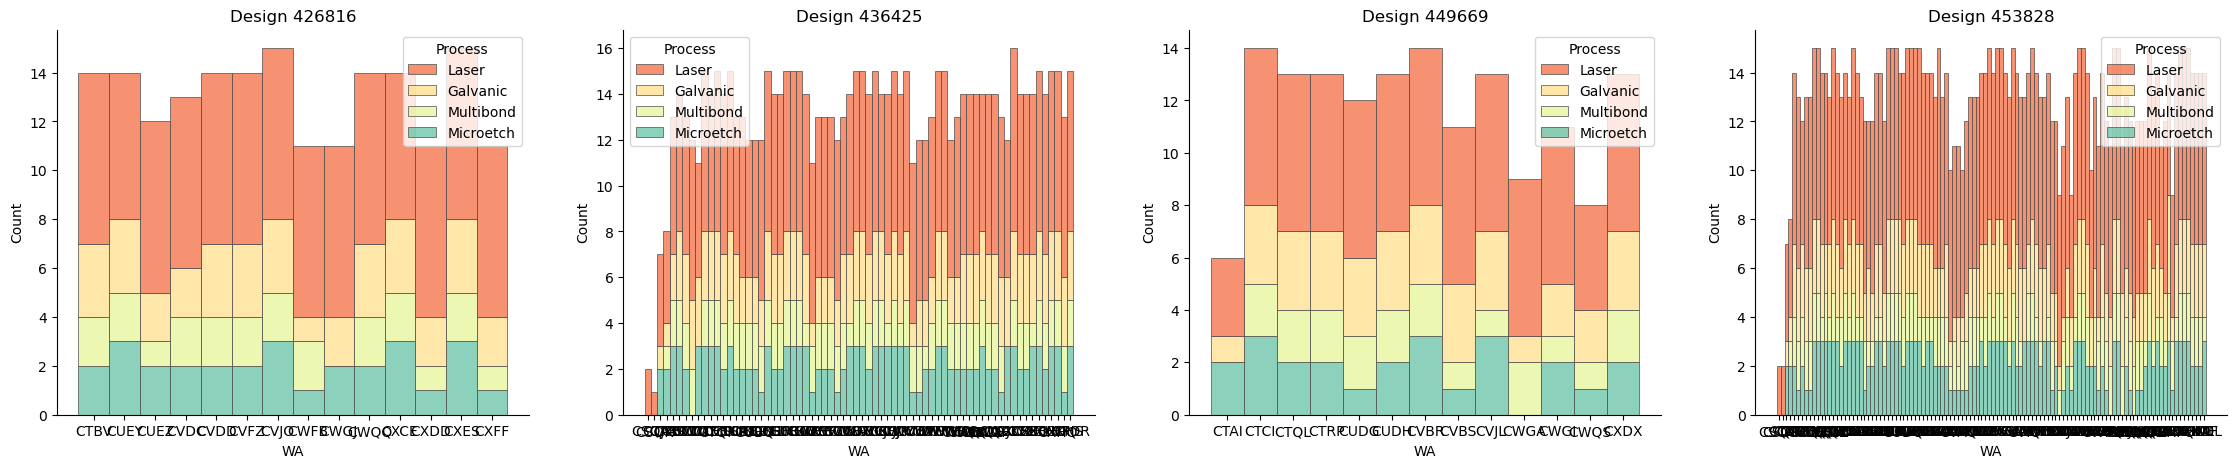

In [ ]:
designs = list(d.keys())

f, ax = plt.subplots(1,len(designs),figsize=(7*len(designs), 5))
sns.despine(f)

for i, sap in enumerate(designs):
    
    df_plot = df_pc.set_index("SAP").loc[sap].drop_duplicates(subset = ["WA","PaPos"])
    
    sns.histplot(data = df_plot ,x="WA", hue="Process", hue_order=["Laser","Galvanic","Multibond","Microetch"],
                 multiple="stack",palette="Spectral",edgecolor=".3",linewidth=.5,ax=ax[i])
    ax[i].set_title(f"Design {sap}")

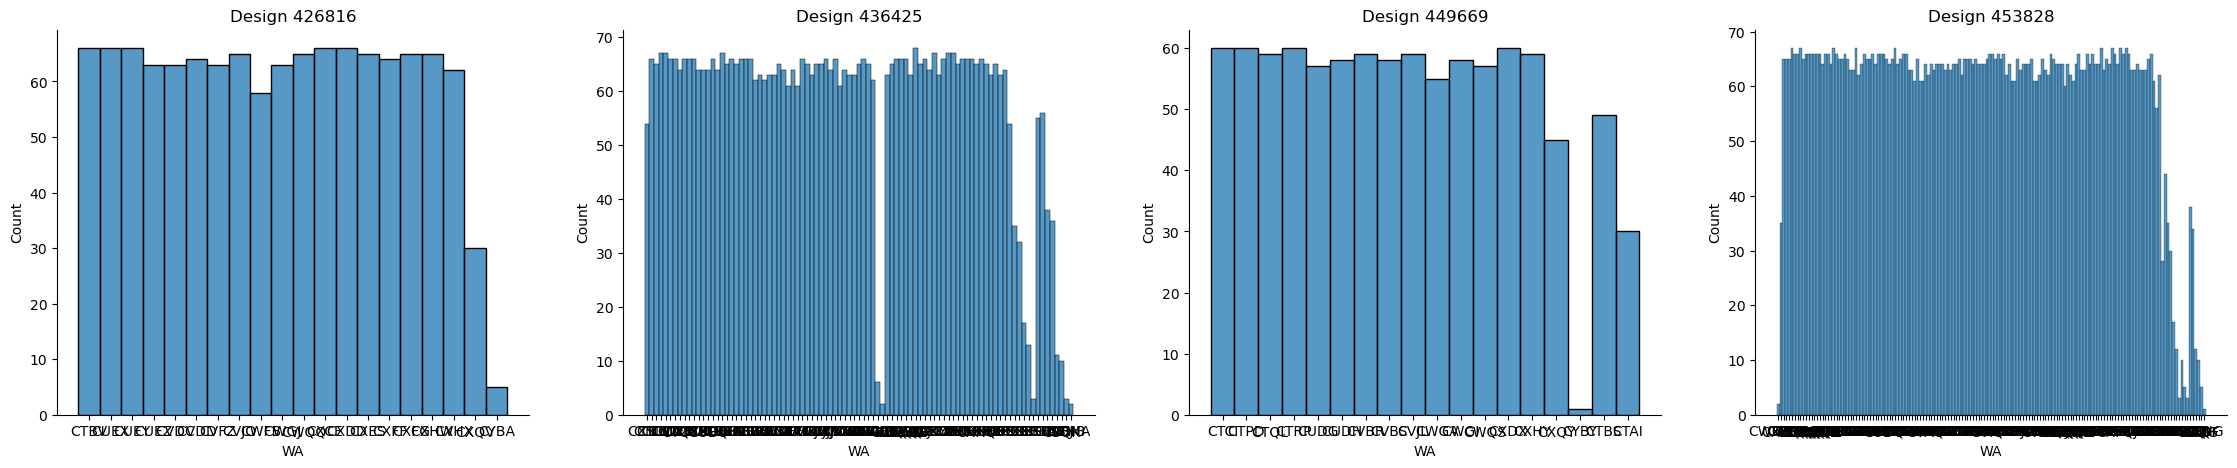

In [ ]:
designs = list(d.keys())

f, ax = plt.subplots(1,len(designs),figsize=(7*len(designs), 5))
sns.despine(f)

for i, sap in enumerate(designs):
    
    df_plot = df_book.set_index("SAP").loc[sap].drop_duplicates(subset = ["WA","PaPosNumber"])
    
    sns.histplot(data = df_plot ,x="WA",ax=ax[i])#, hue="Process", hue_order=["Laser","Galvanic","Multibond","Microetch"],
                 #multiple="stack",palette="Spectral",edgecolor=".3",linewidth=.5,ax=ax[i])
    ax[i].set_title(f"Design {sap}")

In [ ]:
df_rec.groupby(["SAP_Number","Revision"])["StepNumber"].count()

SAP_Number  Revision
426816      5           98
426819      0           98
436425      3           98
449669      15          95
453828      30          98
Name: StepNumber, dtype: int64

## 7. From Pandas to Numpy

### 7.1 Normalize Y

<Axes: >

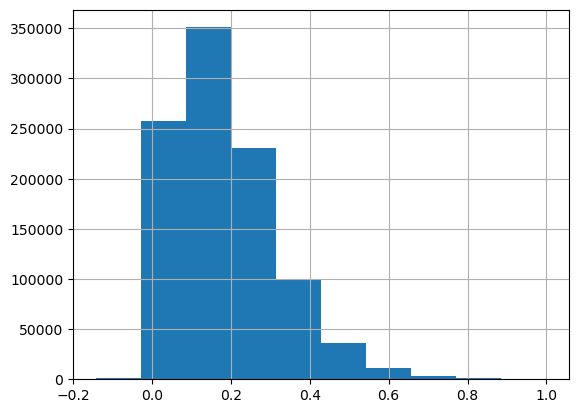

In [ ]:
max_Y_value = df_ist_tr["Value"].max() 
df_ist_tr["Value_Norm"] = df_ist_tr["Value"]/max_Y_value 
df_ist_tr["Value"].hist()

### 7.2 Convert everything to numeric (Tokenize)

In [ ]:
# CONVERT TIME

def explode_time_components(df,time_label):
    df = df.copy()
    components_labels = ["Year","Month","Day","Hour","Minute"]
    
    df[components_labels[0]] = pd.DatetimeIndex(df[time_label]).year
    df[components_labels[1]] = pd.DatetimeIndex(df[time_label]).month
    df[components_labels[2]] = pd.DatetimeIndex(df[time_label]).day
    df[components_labels[3]] = pd.DatetimeIndex(df[time_label]).hour
    df[components_labels[4]] = pd.DatetimeIndex(df[time_label]).minute
    
    return df, components_labels

df_pc_numeric,time_cmp = explode_time_components(df_pc.sort_values("id"),"Time")
df_ist_numeric,_ = explode_time_components(df_ist_tr.sort_values("id"),"CreateDate")

In [ ]:
if all(df_pc_numeric["id"].drop_duplicates().to_numpy() == df_ist_numeric["id"].drop_duplicates().to_numpy()):
    print("All IDs are aligned!")

All IDs are aligned!


### 7.4 Sequentialize input with multiprocesses

In [ ]:


features_X = ["Value","Pos"]
features_Y = ["Value","Zyklus"]

features_X.extend(time_cmp)
features_Y.extend(time_cmp)

sequencer_X = Sequencer(df=df_pc_numeric, features=features_X, id_label = "id", sort_label="PaPos", max_seq_len=1515)
sequencer_Y = Sequencer(df=df_ist_numeric, features=features_Y, id_label = "id", sort_label="Zyklus", max_seq_len=250)

args = sequencer_X.get_ids()

In [ ]:
# works but slow and don't use all CPU #225 min

import os
os.environ["OPENBLAS_MAIN_FREE"] = "1" #aiuta poco


x_list = []
y_list = []

def to_numpy_sequence(fun,args):
    
    seq_list = []
    
    try:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for result in executor.map(fun, args):
                seq_list.append(result)

    except Exception as e:
        print(f"Error occurred {e}")
    
    return np.array(seq_list)


X_np = to_numpy_sequence(sequencer_X.get_seq,args)
Y_np = to_numpy_sequence(sequencer_Y.get_seq,args)

In [ ]:
with open(output_data_path + "X_np.npy", 'wb') as f:
    np.save(f, X_np)
    
with open(output_data_path + "Y_np.npy", 'wb') as f:
    np.save(f, Y_np)

In [ ]:
# def convert_to_numpy(df,features,id_label,sort_label,max_seq_len):
    
#     arr_v = None
    
#     for i in tqdm(df[id_label].unique().tolist()):
#         arr_h = []

#         for j in features:
#             fea = df.set_index(id_label).loc[i].sort_values(sort_label)[j].tolist()
#             n_zeros = max_seq_len-len(fea)
#             if n_zeros < 0:
#                 raise ValueError(f"Choose a maximum sequence length > {len(fea)}")
#             fea.extend([0 for i in range(n_zeros)])
#             arr_h.append(fea)

#         if arr_v is None:
#             arr_v = np.array([arr_h])
#         else:
#             arr_v = np.concatenate((arr_v,np.array([arr_h])),axis=0)
        
#     return arr_v

# features_X = ["Value","Pos"]
# features_Y = ["Value","Zyklus"]

# features_X.extend(time_cmp)
# features_Y.extend(time_cmp)

# X_np = convert_to_numpy(df_pc_numeric[:1000],features_X,"id","PaPos",1500)
# Y_np = convert_to_numpy(df_ist_numeric[:1000],features_Y,"id","Zyklus",250)

# print(f"X shape = (BATCH_SIZE, # features, max sequence length) = {X_np.shape}")
# print(f"Y shape = (BATCH_SIZE, # features, max sequence length) = {Y_np.shape}")

In [ ]:
# SAVE

# with open(data_path + "/01_Generated_Files/X_np.npy", 'wb') as f:
#     np.save(f, X_np)
    
# with open(data_path + "/01_Generated_Files/Y_np.npy", 'wb') as f:
#     np.save(f, Y_np)

In [ ]:
# df_book_sel = select_columns(df_book,["WA"],"CXOF")

# df_plasma_sel = select_columns(df_plasma,["WA"],"CXOF")
# df_laser_sel = select_columns(df_laser,["WA"],"CXOF")
# df_galva_sel = select_columns(df_galva,["WA"],"CXOF")
# df_micro_sel = select_columns(df_micro,["WA"],"CXOF")
# df_multi_sel = select_columns(df_multi,["WA"],"CXOF")

# col_plasma = "T_StartTemp Mean_2"
# col_laser = "P_ActualPower"

# def print_info(df,step,process_label,PaPos_label,machineID_label):
#     df_step = df[df[PaPos_label]==step]
#     if machineID_label != False:
#         machineID = df_step[machineID_label].iloc[0]
#     else:
#         machineID = False
#     print(f"{step}, {process_label}, {machineID}, length = {len(df_step)}")

# for step in df_book_sel["PaPosNumber"]:
    
#     if step in list(df_plasma_sel["Position"]):
#         print_info(df_plasma_sel,step,"Plasma","Position","MachineID")
        
#     if step in list(df_laser_sel["PaPosNr"]):
#         # laser_step = df_laser_sel[df_laser_sel["PaPosNr"]==step]
#         # len_laser = np.mean(df_laser_sel[df_laser_sel["PaPosNr"]==step][col_laser])
#         # print(step,"Laser", len(laser_step))
#         print_info(df_laser_sel,step,"Laser","PaPosNr","Machine")
        
        
#     if step in list(df_galva_sel["PaPosNr"]):
#         # print(step,"Galvanic")
#         print_info(df_galva_sel,step,"Galvanic","PaPosNr","AnlagenName")
        
#     if step in list(df_micro_sel["PaPosNr"]):
#         print(step,"Microetch")
#         print_info(df_micro_sel,step,"Microetch","PaPosNr",False)
        
#     if step in list(df_multi_sel["PaPosNr"]):
        
#         print_info(df_multi_sel,step,"Multibond","PaPosNr",False)